# Advanced Analysis of European Weather Warnings

Weather warnings often cover specific geographical regions. The MeteoAlarms API provides these areas as GeoJSON geometries. Let's see how we can visualize these warning areas with appropriate styling based on severity levels.

First, let's import the necessary libraries:

In [1]:
from meteoalarm import MeteoAlarm
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import json
import pandas as pd
from shapely.errors import ShapelyError
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
from matplotlib.patches import Patch

## Request the desired warnings

For this example, we request the all available warnings for countries and print the number of warnings:

In [2]:
all_warnings = MeteoAlarm()
len(all_warnings)

2216

In [ ]:
# Define a color mapping for different severity levels
severity_colors = {
    'Severe': {"face": "#FF204E", "edge": "#A0153E"},
    'Moderate': {"face": "#FFB200", "edge": "#EB5B00"},
    'Minor': {"face": "#FFFF00", "edge": "#CCCC00"},
    'Extreme': {"face": "#9B1C31", "edge": "#800000"}
}

# Default color for any undefined severity levels
default_color = {"face": "#AAAAAA", "edge": "#666666"}

# Create empty lists to store geometries and attributes
geometries = []
attributes = []

# Loop through all warnings
for idx, warning in enumerate(all_warnings):
    try:
        if hasattr(warning, 'geometry') and warning.geometry:
            # Parse the GeoJSON string
            geojson_dict = json.loads(warning.geometry)

            # Create geometry object
            geometry = shape(geojson_dict)

            # Store geometry and attributes
            geometries.append(geometry)
            attributes.append({
                'id': idx,
                'country': warning.country if hasattr(warning, 'country') else 'Unknown',
                'headline': warning.headline if hasattr(warning, 'get_headline') else 'No headline',
                'severity': warning.severity if hasattr(warning, 'severity') else 'Unknown'
            })
    except (json.JSONDecodeError, ShapelyError, AttributeError) as e:
        print(f"Error processing warning {idx}: {e}")
        continue

# Create a GeoDataFrame with all geometries
all_warnings_df = gpd.GeoDataFrame(attributes, geometry=geometries, crs="EPSG:4326")

# Convert to Web Mercator projection for contextily
all_warnings_web = all_warnings_df.to_crs(epsg=3857)

# Create a figure with a larger size for the overview map
fig, ax = plt.subplots(figsize=(15, 12))

# Plot each warning with appropriate styling based on severity
for idx, row in all_warnings_web.iterrows():
    severity = row['severity']
    colors = severity_colors.get(severity, default_color)

    # Plot with appropriate styling
    all_warnings_web.iloc[[idx]].plot(
        ax=ax,
        alpha=0.6,
        edgecolor=colors["edge"],
        facecolor=colors["face"],
        hatch='//' if severity in ['Severe', 'Extreme'] else '\\\\' if severity == 'Moderate' else None,
        linewidth=1.5
    )

# Add background map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set a fixed bounding box for Europe
# These coordinates are in Web Mercator (EPSG:3857)
# Approximate bbox for Europe: [min_x, max_x, min_y, max_y]
europe_bbox = [-1200000, 4700000, 4000000, 9000000]  # Adjust these values as needed
ax.set_xlim([europe_bbox[0], europe_bbox[1]])
ax.set_ylim([europe_bbox[2], europe_bbox[3]])

# Add title
plt.suptitle('Overview of All Current Weather Warnings', fontsize=20)

# Create a custom legend
legend_elements = [
    Patch(facecolor=severity_colors[sev]["face"], edgecolor=severity_colors[sev]["edge"],
          label=sev, alpha=0.6, hatch='//' if sev in ['Severe', 'Extreme'] else '\\\\' if sev == 'Moderate' else None)
    for sev in severity_colors if any(row['severity'] == sev for _, row in all_warnings_df.iterrows())
]
ax.legend(handles=legend_elements, loc='lower right', title='Warning Severity')

# Add a timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
plt.figtext(0.02, 0.02, f"Generated: {timestamp}", fontsize=10)

# Remove axis
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

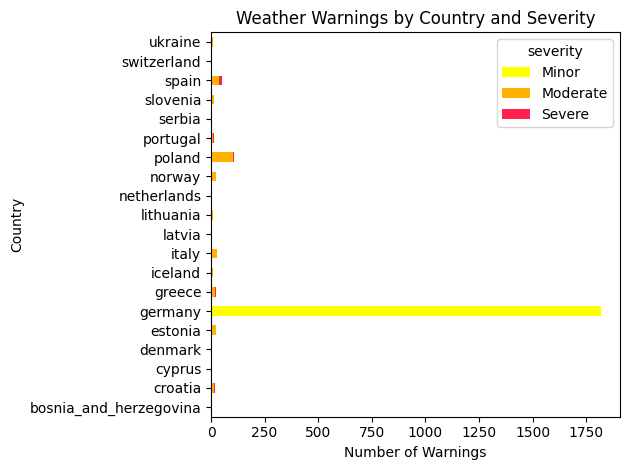

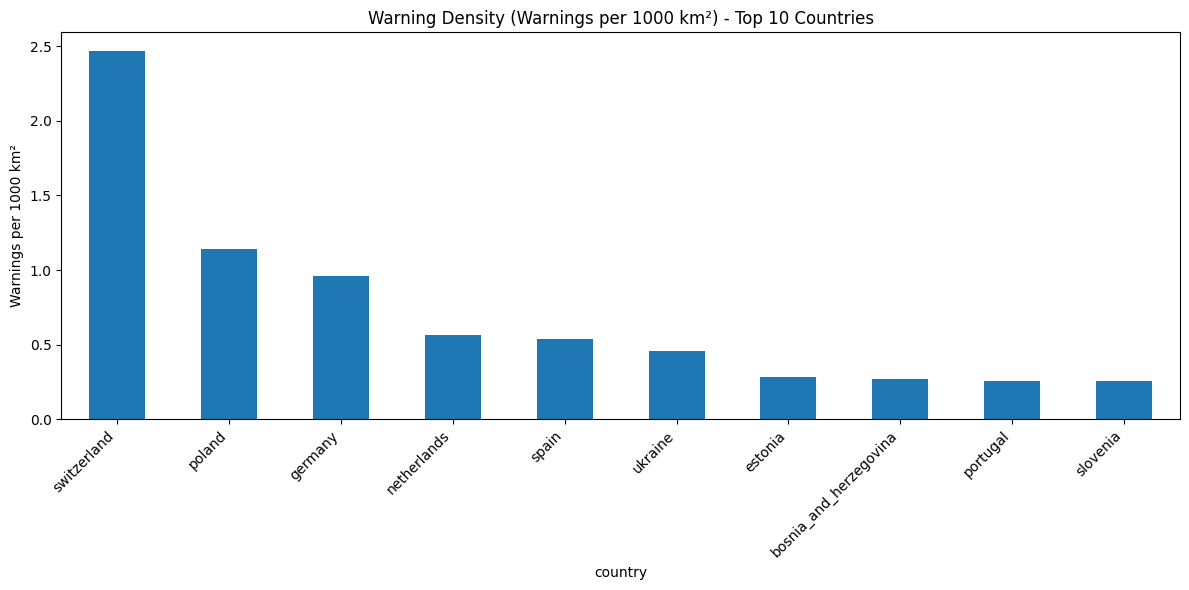

In [6]:
# Count warnings by country and severity
country_counts = all_warnings_df.groupby(['country', 'severity']).size().unstack(fill_value=0)

# Plot a horizontal bar chart
plt.figure(figsize=(12, max(6, len(country_counts) * 0.4)))
country_counts.plot(kind='barh', stacked=True, 
                   color=[severity_colors.get(col, default_color)["face"] for col in country_counts.columns])
plt.title('Weather Warnings by Country and Severity')
plt.xlabel('Number of Warnings')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# Calculate warning density (warnings per area)
if 'geometry' in all_warnings_df.columns:
    # Calculate area in square kilometers
    all_warnings_df['area_km2'] = all_warnings_df.to_crs('+proj=cea').area / 10**6

    # Group by country and calculate total area and count
    area_stats = all_warnings_df.groupby('country').agg(
        total_area_km2=('area_km2', 'sum'),
        warning_count=('id', 'count')
    )

    # Calculate warnings per 1000 km²
    area_stats['warnings_per_1000km2'] = area_stats['warning_count'] / area_stats['total_area_km2'] * 1000

    # Plot the warning density
    plt.figure(figsize=(12, 6))
    area_stats.sort_values('warnings_per_1000km2', ascending=False).head(10)['warnings_per_1000km2'].plot(kind='bar')
    plt.title('Warning Density (Warnings per 1000 km²) - Top 10 Countries')
    plt.ylabel('Warnings per 1000 km²')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [10]:
# Create a function to display warning details
def show_warning_details(warning_id):
    if 0 <= warning_id < len(all_warnings):
        warning = all_warnings[warning_id]

        # Create a figure for the specific warning
        fig, ax = plt.subplots(figsize=(10, 8))

        # Get geometry and convert to GeoDataFrame
        geojson_dict = json.loads(warning.geometry)
        geometry = shape(geojson_dict)
        gdf = gpd.GeoDataFrame(geometry=[geometry], crs="EPSG:4326")
        gdf_web = gdf.to_crs(epsg=3857)

        # Get colors based on severity
        severity = warning.severity
        colors = severity_colors.get(severity, default_color)

        # Plot the warning
        gdf_web.plot(
            ax=ax,
            alpha=0.6,
            edgecolor=colors["edge"],
            facecolor=colors["face"],
            hatch='//' if severity in ['Severe', 'Extreme'] else '\\\\' if severity == 'Moderate' else None,
            linewidth=2
        )

        # Add background map
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

        # Add title with warning details
        plt.title(f"{warning.country.title()}: {warning.get_headline()}\nSeverity: {warning.severity}", 
                 fontsize=14)

        # Display additional information if available
        info_text = ""
        if hasattr(warning, 'onset') and warning.onset:
            info_text += f"Onset: {warning.onset}\n"
        if hasattr(warning, 'expires') and warning.expires:
            info_text += f"Expires: {warning.expires}\n"

        plt.figtext(0.1, 0.01, info_text, fontsize=12)

        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning ID {warning_id} is out of range.")

# Create a dropdown widget to select warnings
warning_dropdown = widgets.Dropdown(
    options=[(f"{w.country.title()}: {w.get_headline(lang="en-GB")}..." if hasattr(w, 'get_headline') else f"Warning {i}", i) 
             for i, w in enumerate(all_warnings) if hasattr(w, 'geometry') and w.geometry],
    description='Select Warning:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='80%')
)

# Create an output widget to display the selected warning
output = widgets.Output()

# Define the callback function
def on_change(change):
    with output:
        clear_output()
        show_warning_details(change['new'])

# Register the callback
warning_dropdown.observe(on_change, names='value')

# Display the widgets
display(warning_dropdown, output)

Dropdown(description='Select Warning:', layout=Layout(width='80%'), options=(('Bosnia_And_Herzegovina: Rain Ye…

Output()